In [783]:
import os
import pandas as pd
pd.options.display.max_rows = 10
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import timedelta
cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']

dict = {}

for cantonId in cantonKeys:
    d = pd.read_csv("data/merged/"+cantonId+".csv")
    d = d.set_index('date')
    dict[cantonId] = d
    
interpolMet = 'linear'

In [784]:

yesterday = str(datetime.date.today()- timedelta(days = 1))
for cantonId in cantonKeys:
    
    # we discard the first days of 2020 and future data
    dict[cantonId] = dict[cantonId]['2020-02-15':'2021-04-05'] #use '2021-04-05' for testing and yesterday for production
    dict[cantonId].index = pd.to_datetime(dict[cantonId].index)
    
    
    # interpolate weekly FOPH dataCases entries 0 - 9
    for c1 in ['Cases','Death','Hosp']:
        for c2 in ['entries','inz_entries','inzsumTotal']:
            for c3 in ['0 - 9','10 - 19','20 - 29','30 - 39','40 - 49','50 - 59','60 - 69','70 - 79','80+']:
                # fill first row with 0
                dict[cantonId].loc['2020-02-15',c1 + " " + c2 + " " + c3] = 0
                # interpolate the rest
                dict[cantonId][[c1 + " " + c2 + " " + c3]] = dict[cantonId][[c1 + " " + c2 + " " + c3]].interpolate(method=interpolMet)
            for c4 in ['male','female']:
                # fill first row with 0
                dict[cantonId].loc['2020-02-15',c1 + " " + c2 + " " + c4] = 0
                # interpolate the rest
                dict[cantonId][[c1 + " " + c2 + " " + c4]] = dict[cantonId][[c1 + " " + c2 + " " + c4]].interpolate(method=interpolMet)
    
    
    # fill missing vaccine data
    vaccine = ['VaccDosesAdministered sumTotal','VaccDosesAdministered per100PersonsTotal', 
               'FullyVaccPersons sumTotal', 'FullyVaccPersons per100PersonsTotal']
    dict[cantonId].loc['2020-02-15',vaccine] = 0
    dict[cantonId][vaccine] = dict[cantonId][vaccine].fillna(method='ffill')
    
    # fill missing total hospital capacities
    hospitalCols = ['ICU_Capacity','ICU_FreeCapacity','Total_Capacity','Total_FreeCapacity']
    dict[cantonId][hospitalCols] = dict[cantonId][hospitalCols].interpolate(method=interpolMet)
    dict[cantonId]['ICU_Capacity'].fillna(method='bfill', inplace=True)
    dict[cantonId]['ICU_FreeCapacity'].fillna(method='bfill', inplace=True)
    dict[cantonId]['Total_Capacity'].fillna(method='bfill', inplace=True)
    dict[cantonId]['Total_FreeCapacity'].fillna(method='bfill', inplace=True)

    # ICU_Covid19Patients + ICU_NonCovid19Patients = ICU_AllPatients 
    dict[cantonId].loc['2020-02-15','ICU_Covid19Patients'] = 0
    ICUpatientsCols = ['ICU_Covid19Patients','ICU_NonCovid19Patients','ICU_AllPatients']
    dict[cantonId][ICUpatientsCols] = dict[cantonId][ICUpatientsCols].interpolate(method=interpolMet)
    dict[cantonId]['ICU_NonCovid19Patients'].fillna(method='bfill', inplace=True)
    dict[cantonId]['ICU_AllPatients'].fillna(dict[cantonId][['ICU_Covid19Patients','ICU_NonCovid19Patients']].sum(axis=1), inplace=True)

    # Total_Covid19Patients + Total_NonCovid19Patients = Total_AllPatients
    dict[cantonId].loc['2020-02-15','Total_Covid19Patients'] = 0
    patientCols = ['Total_Covid19Patients','Total_NonCovid19Patients','Total_AllPatients']
    dict[cantonId][patientCols] = dict[cantonId][patientCols].interpolate(method=interpolMet)
    dict[cantonId]['Total_NonCovid19Patients'].fillna(method='bfill', inplace=True)
    dict[cantonId]['Total_AllPatients'].fillna(dict[cantonId][['Total_Covid19Patients','Total_NonCovid19Patients']].sum(axis=1), inplace=True)
    
    # fill in missing Google mobility data
    googleMobilityCols = ['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline'
    ,'residential_percent_change_from_baseline']
    dict[cantonId][googleMobilityCols] = dict[cantonId][googleMobilityCols].interpolate(method=interpolMet)
    
    dict[cantonId][googleMobilityCols] = dict[cantonId][googleMobilityCols].fillna(method='ffill')
    
    # fill in missing Intervista mobility data
    
    dict[cantonId][['intervistaMob']] = dict[cantonId][['intervistaMob']].interpolate(method=interpolMet)
    dict[cantonId]['intervistaMob'].fillna(method='ffill', inplace=True)
    
    # fill in missing neighbor incidence   
    dict[cantonId].loc['2020-02-15', 'meanNeighborIncidence'] = 0
    dict[cantonId].loc['2020-02-15', 'maxNeighborIncidence'] = 0
    dict[cantonId][['meanNeighborIncidence','maxNeighborIncidence']] = dict[cantonId][['meanNeighborIncidence','maxNeighborIncidence']].interpolate(method=interpolMet)
        
    # fill in missing r values
    rvalues = ['median_R_mean','median_R_highHPD','median_R_lowHPD']
    dict[cantonId][rvalues] = dict[cantonId][rvalues].interpolate(method=interpolMet)  
    dict[cantonId][rvalues] = dict[cantonId][rvalues].fillna(method='ffill')
    dict[cantonId][rvalues] = dict[cantonId][rvalues].fillna(method='bfill')
  
    # fill in missing variants
    variants = ['lower_ci_day','upper_ci_day','anteil_pos']
    # first detected case for variants of concerne in Switzerland is 2020-10-14
    dict[cantonId].loc['2020-10-13',['lower_ci_day','anteil_pos']] = 0
    dict[cantonId].loc['2020-10-13',['upper_ci_day']] = 100
    dict[cantonId][variants] = dict[cantonId][variants].interpolate(method=interpolMet)
    dict[cantonId][variants] = dict[cantonId][variants].fillna(method='ffill')
    dict[cantonId][variants] = dict[cantonId][variants].fillna(method='bfill')

    # fill in daily incoming missing data
    # entries
    dict[cantonId].loc['2020-02-15',['case_entries','hosp_entries','death_entries','case_inz_entries','hosp_inz_entries','death_inz_entries',
              'case_inzsumTotal','hosp_inzsumTotal','death_inzsumTotal']] = 0
    dict[cantonId][entries] = dict[cantonId][entries].interpolate(method=interpolMet)

    dict[cantonId].loc['2020-02-15','test_inzsumTotal'] = 0
    dict[cantonId][['test_inzsumTotal']] = dict[cantonId][['test_inzsumTotal']].interpolate(method=interpolMet)
    
    if not os.path.exists('data/filled'):
        os.makedirs('data/filled')
    dict[cantonId].to_csv('data/filled/'+cantonId+'.csv')

/home/david/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/david/.local/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/david/.local/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

AI retail_and_recreation_percent_change_from_baseline (#NaN/total): (34/382)


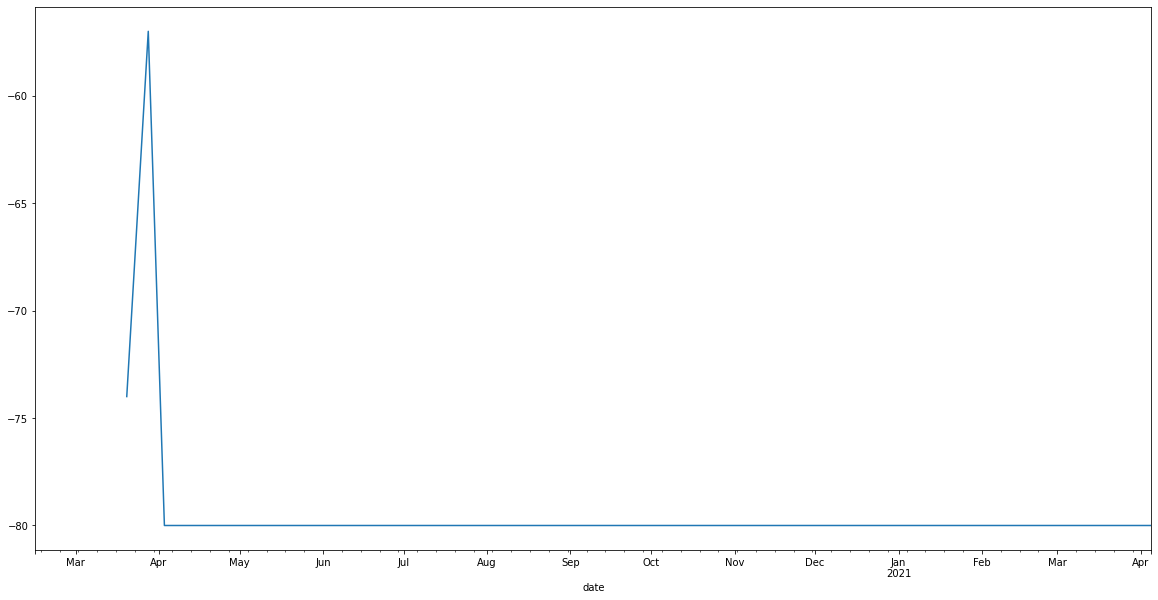

AI grocery_and_pharmacy_percent_change_from_baseline (#NaN/total): (416/0)


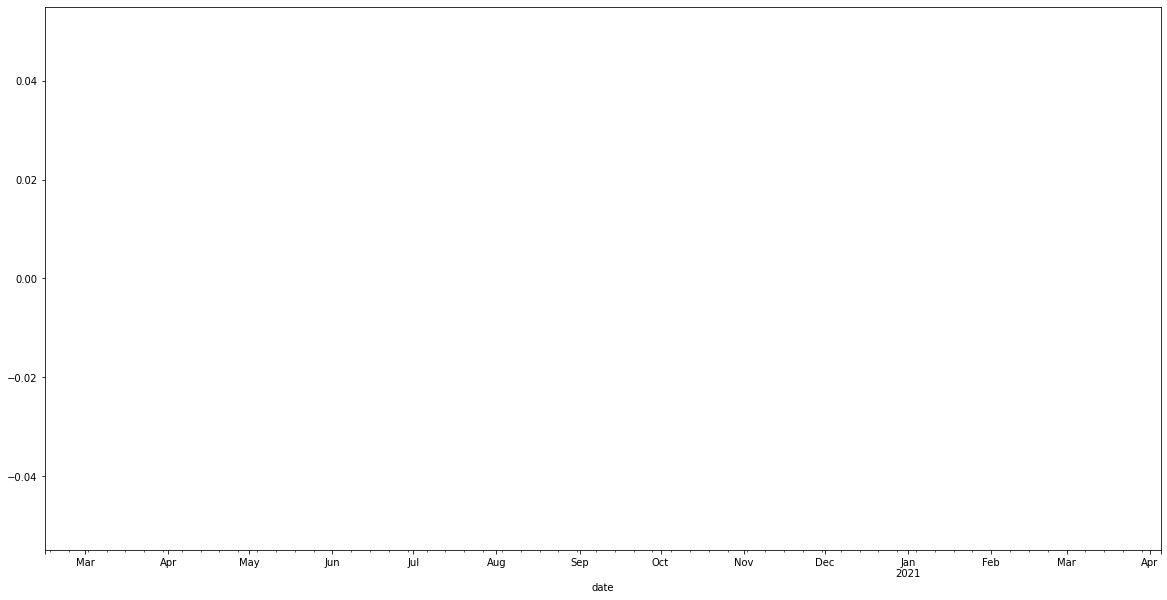

AI parks_percent_change_from_baseline (#NaN/total): (416/0)


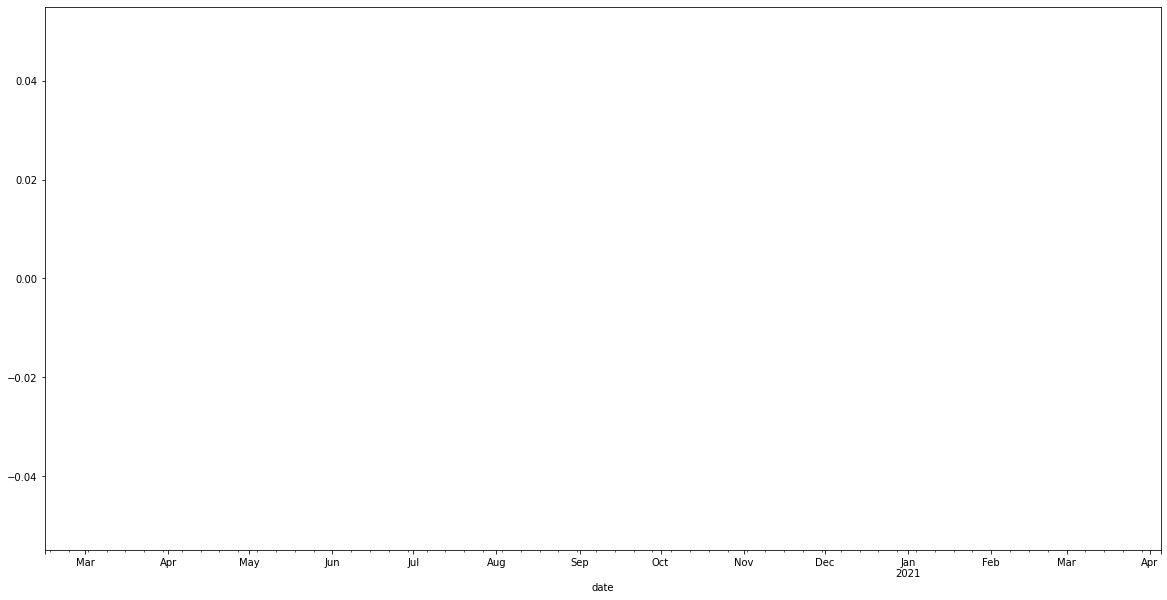

AI transit_stations_percent_change_from_baseline (#NaN/total): (416/0)


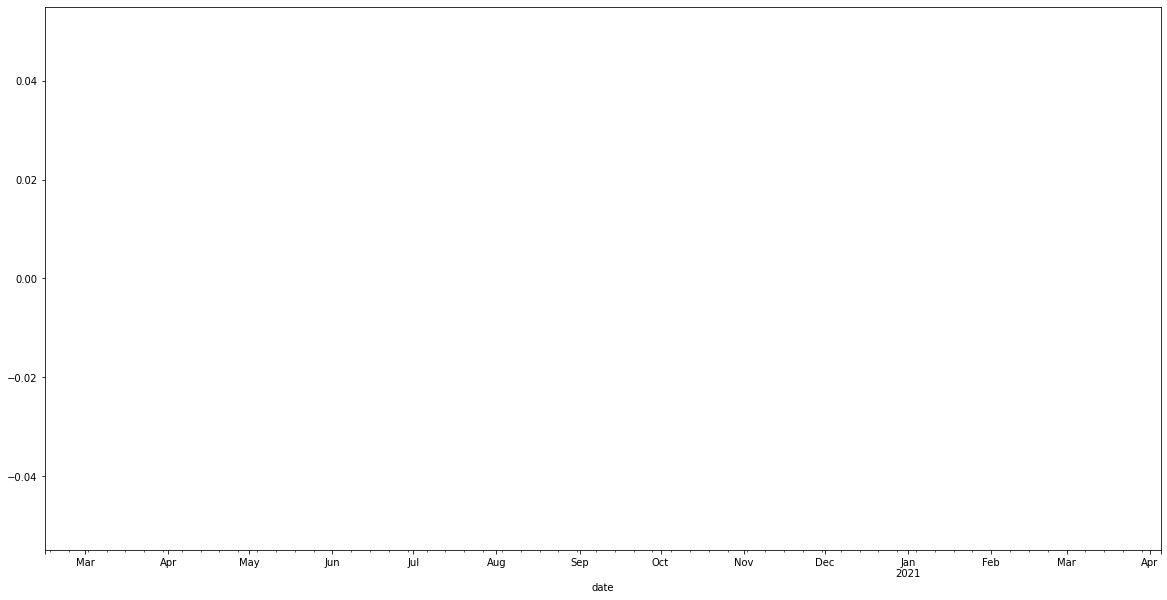

AI workplaces_percent_change_from_baseline (#NaN/total): (2/414)


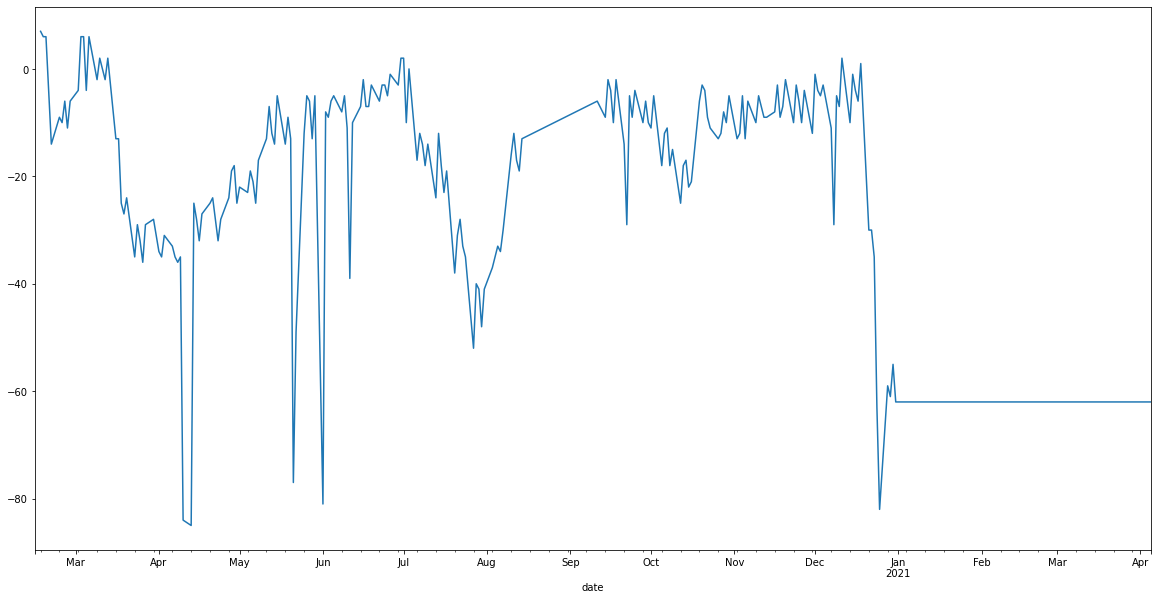

AI residential_percent_change_from_baseline (#NaN/total): (416/0)


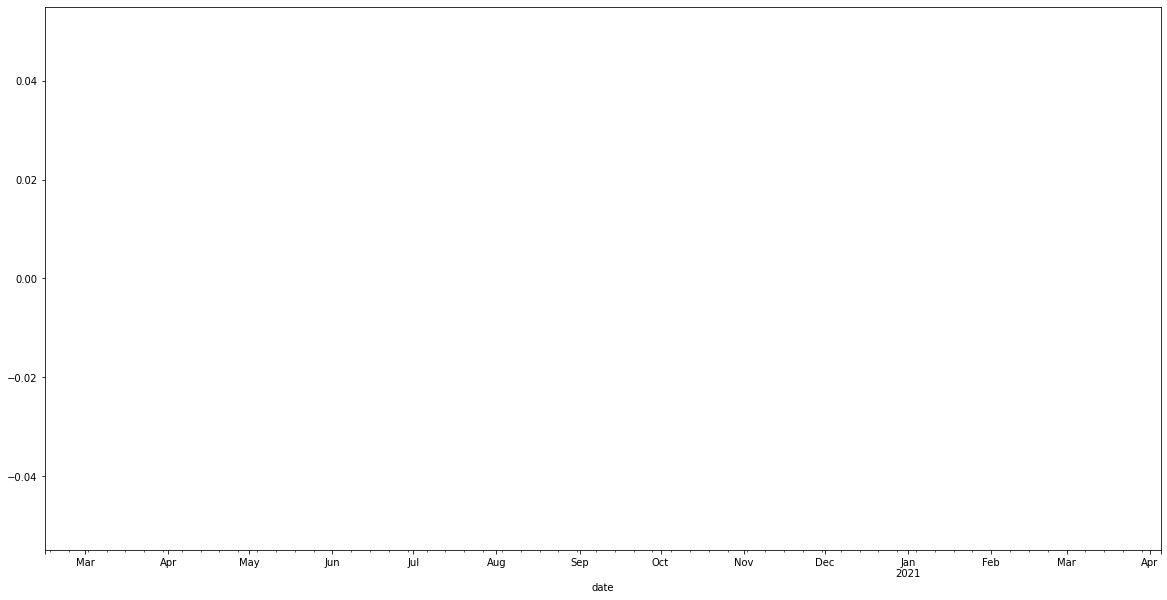

AR parks_percent_change_from_baseline (#NaN/total): (416/0)


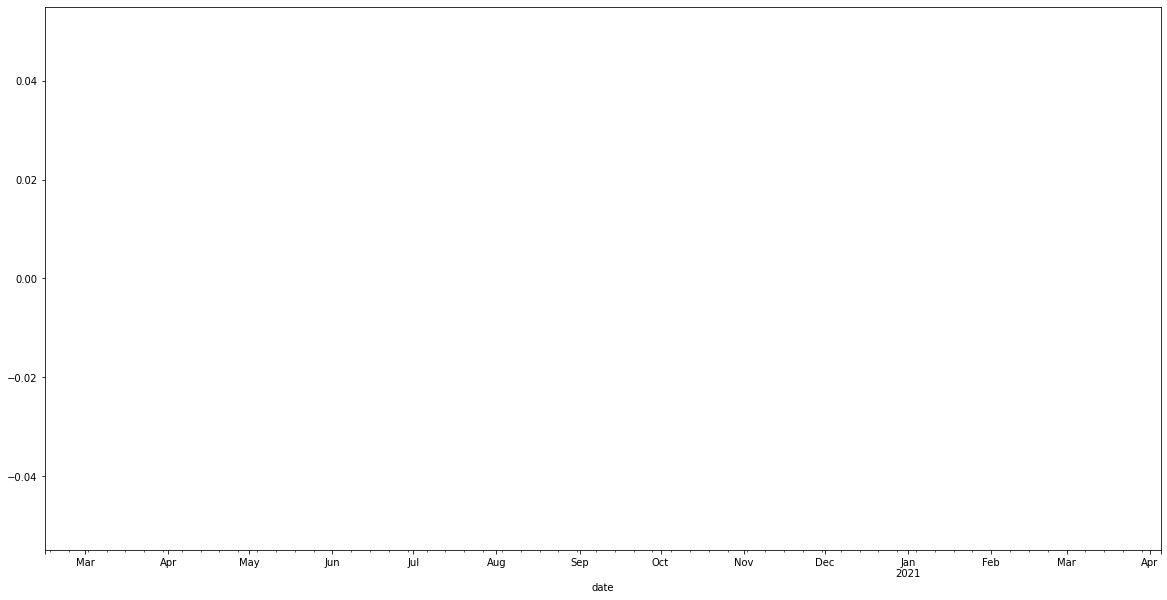

AR residential_percent_change_from_baseline (#NaN/total): (221/195)


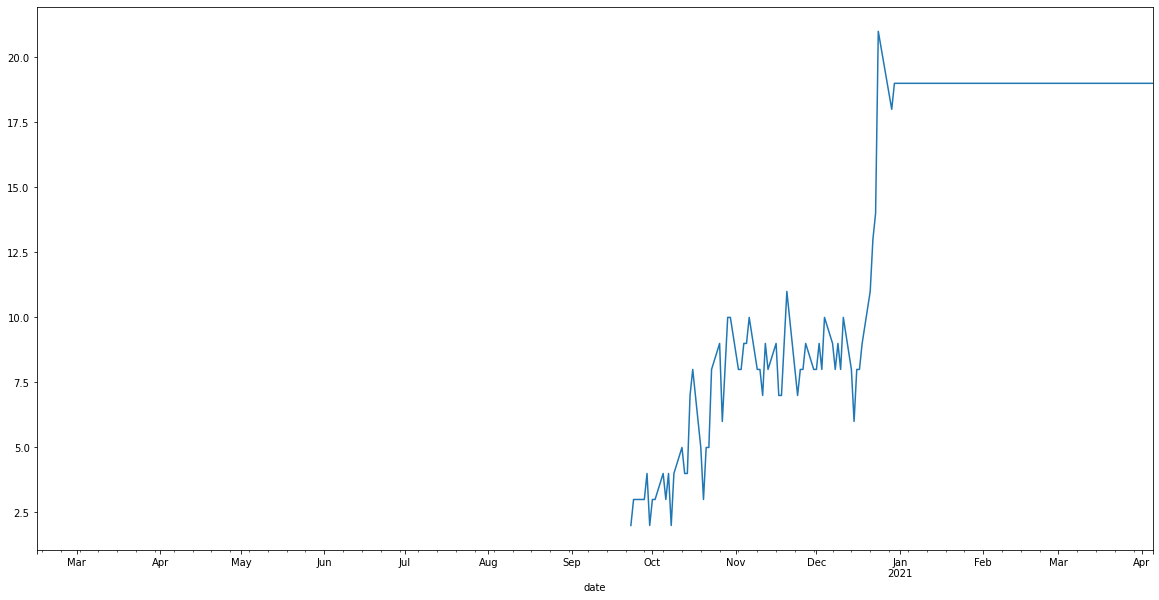

BL parks_percent_change_from_baseline (#NaN/total): (1/415)


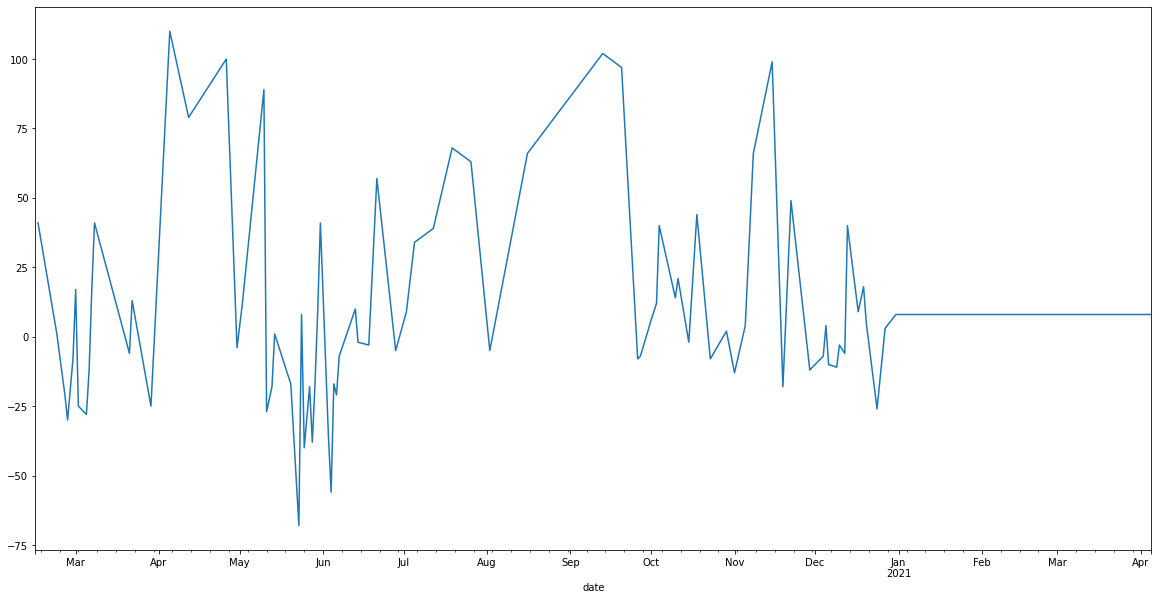

BS residential_percent_change_from_baseline (#NaN/total): (2/414)


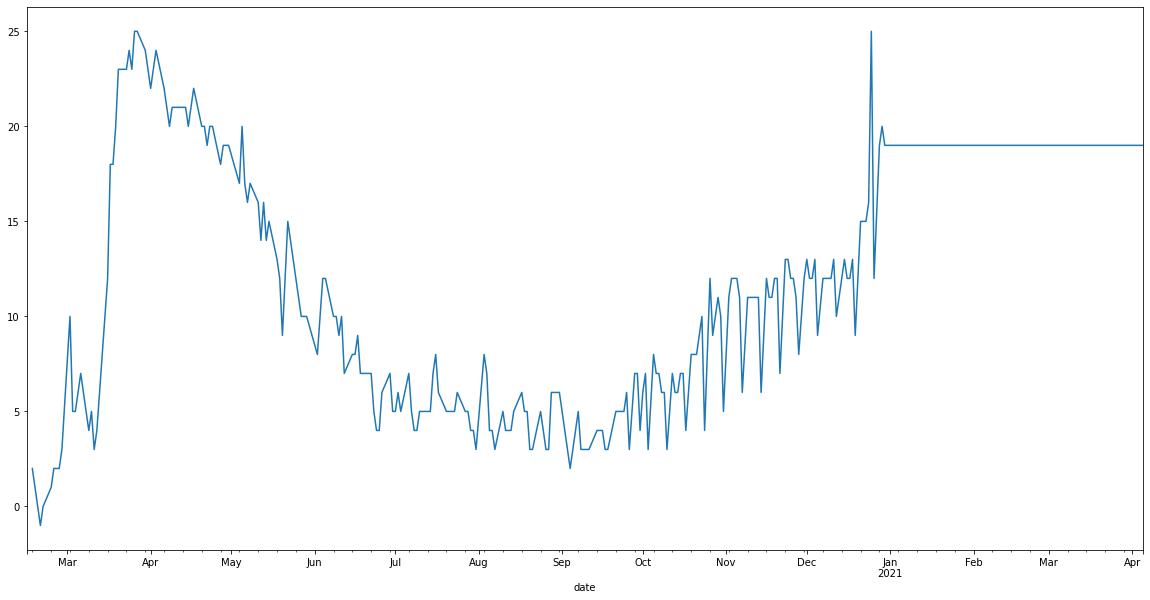

GL parks_percent_change_from_baseline (#NaN/total): (416/0)


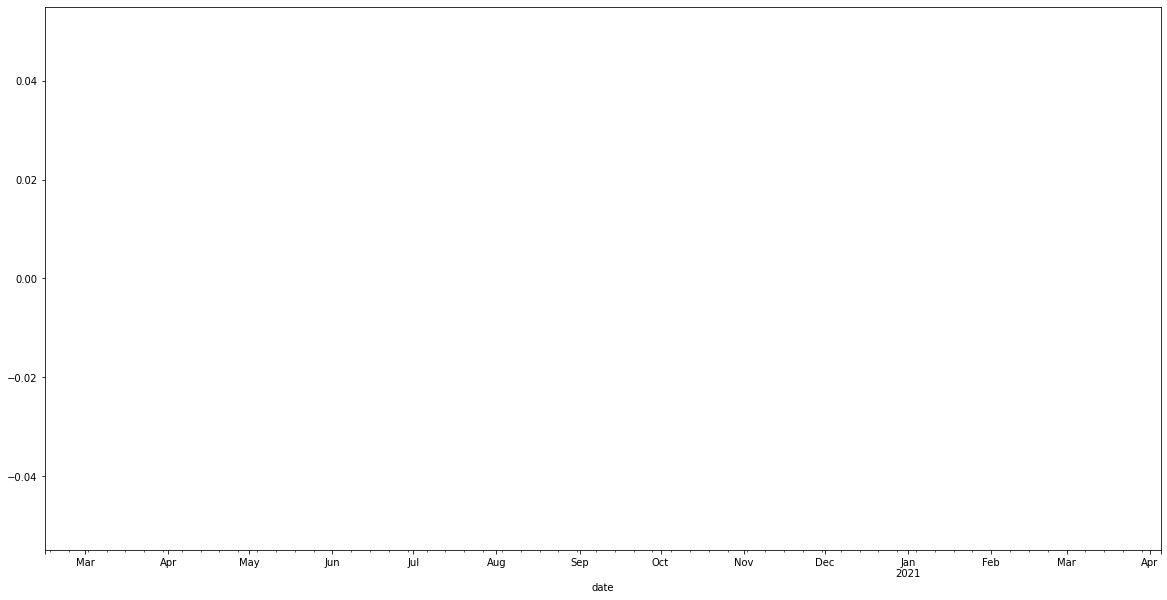

GL residential_percent_change_from_baseline (#NaN/total): (416/0)


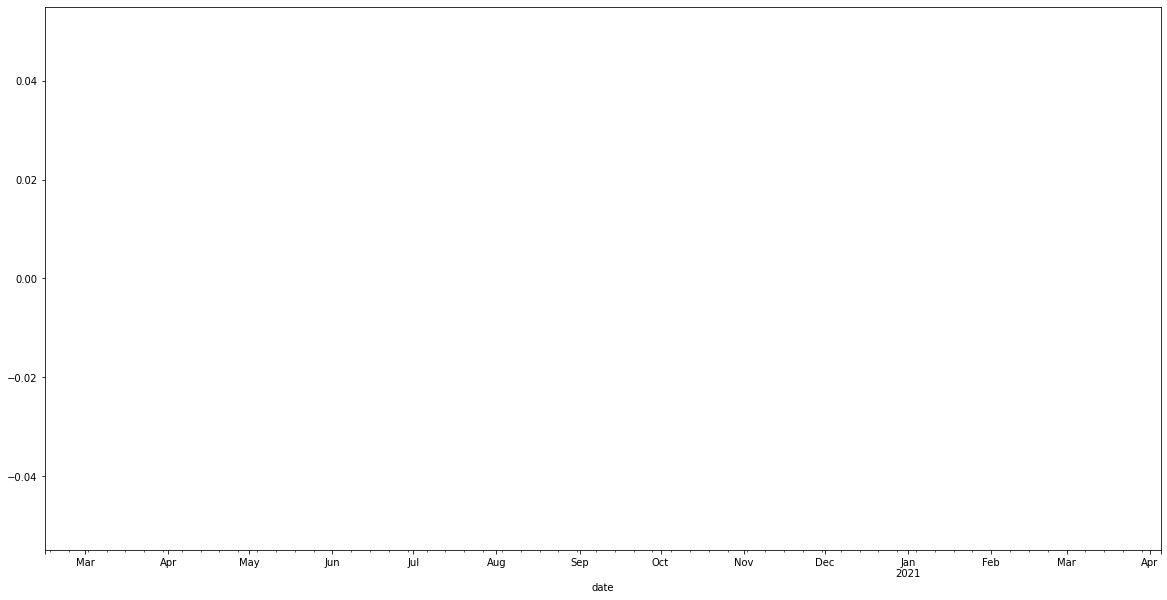

JU parks_percent_change_from_baseline (#NaN/total): (416/0)


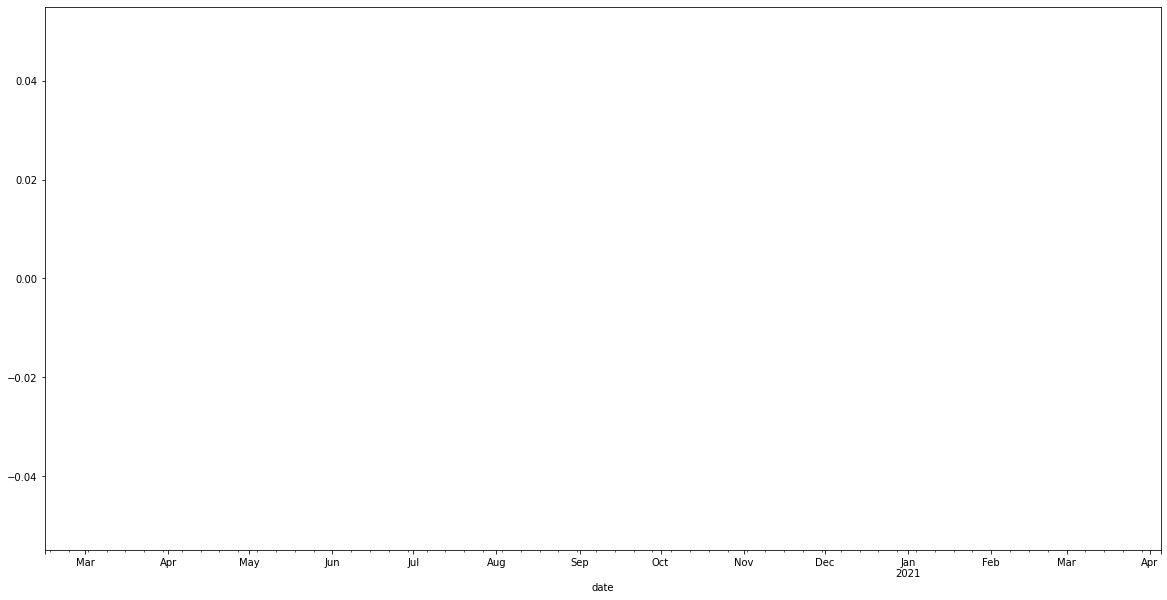

JU residential_percent_change_from_baseline (#NaN/total): (2/414)


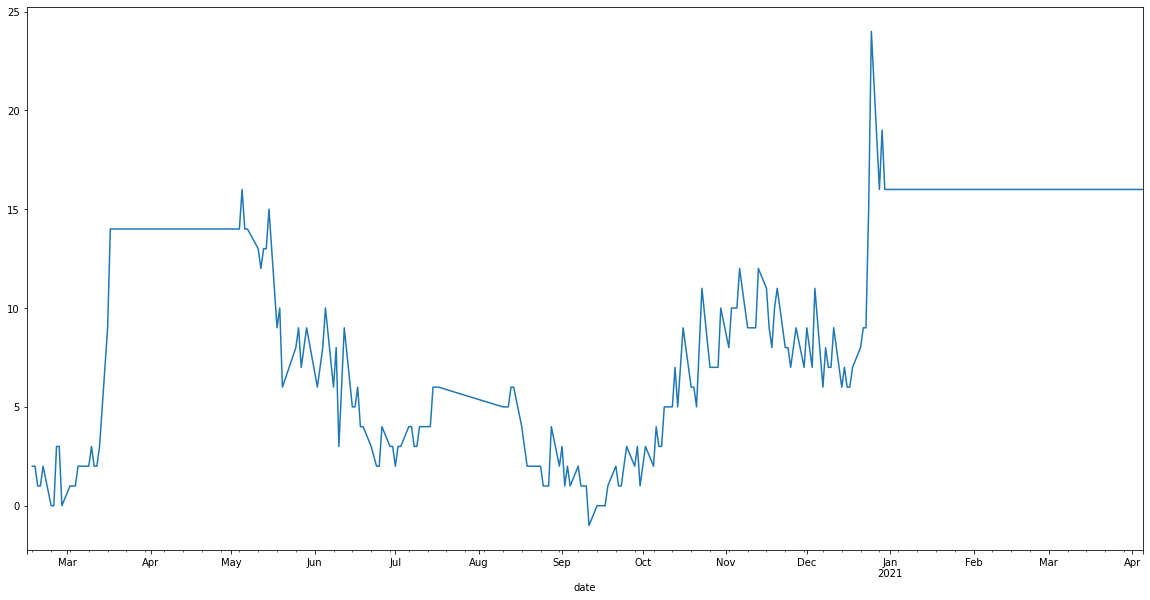

NE parks_percent_change_from_baseline (#NaN/total): (8/408)


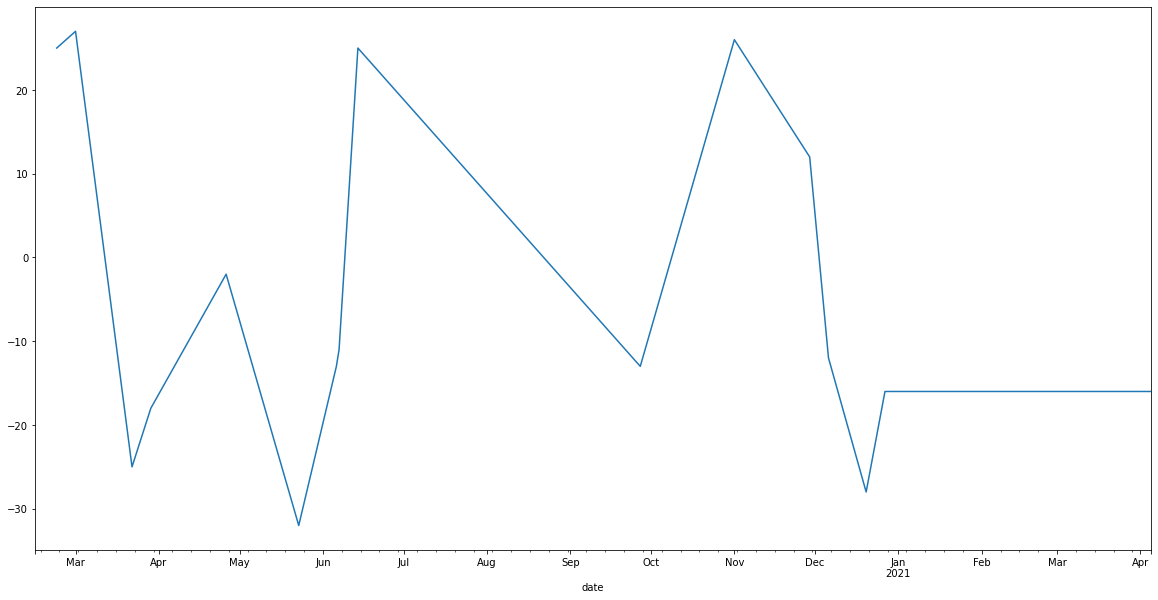

NW parks_percent_change_from_baseline (#NaN/total): (1/415)


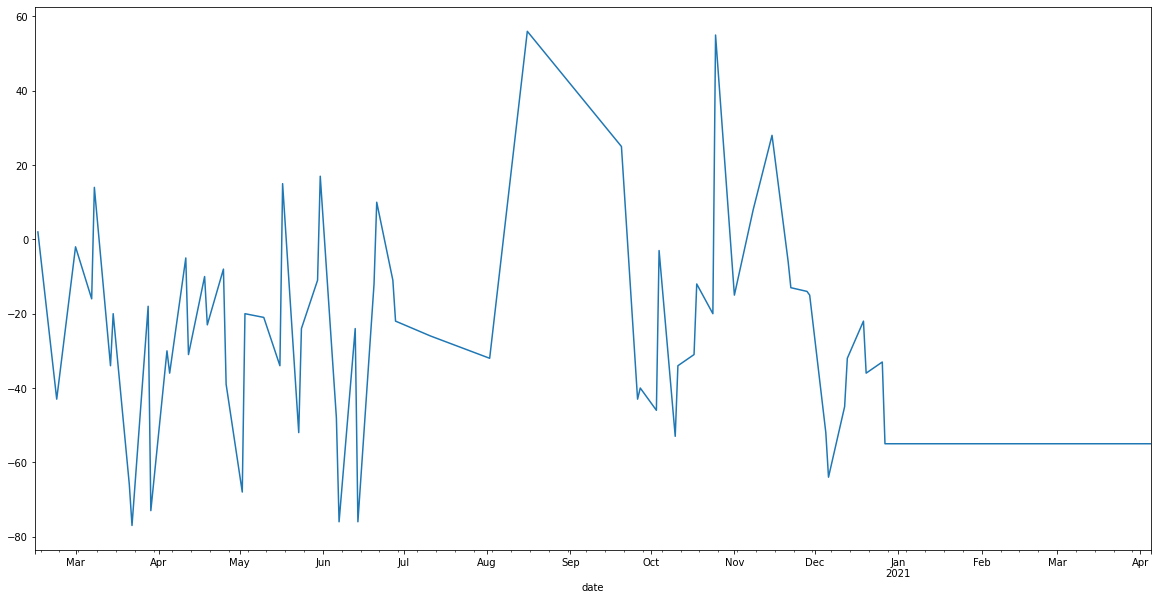

NW residential_percent_change_from_baseline (#NaN/total): (416/0)


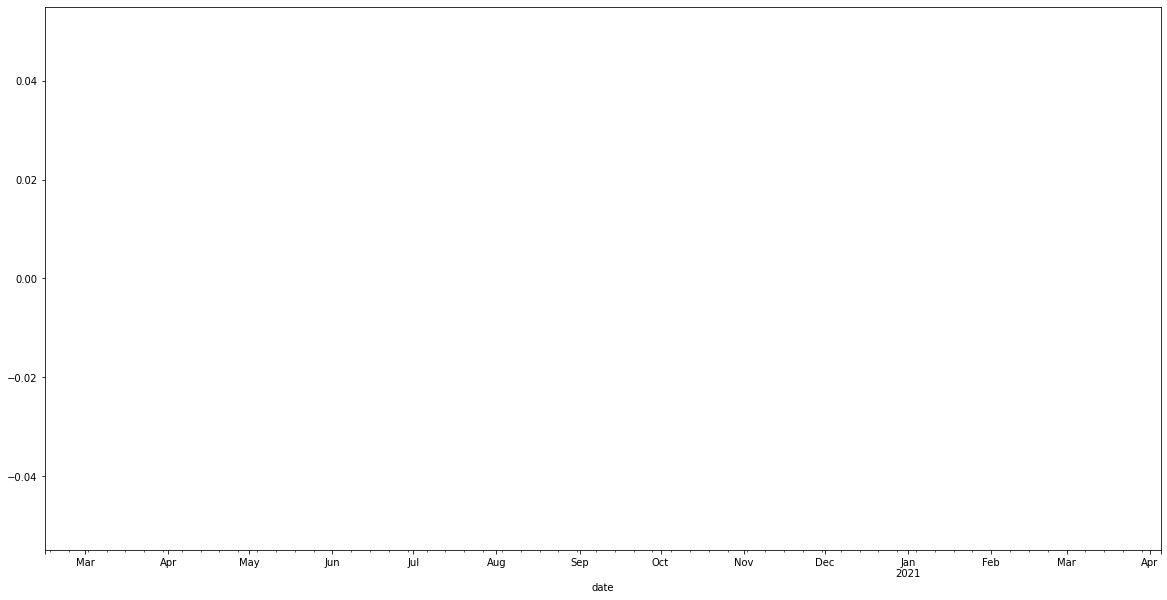

OW parks_percent_change_from_baseline (#NaN/total): (8/408)


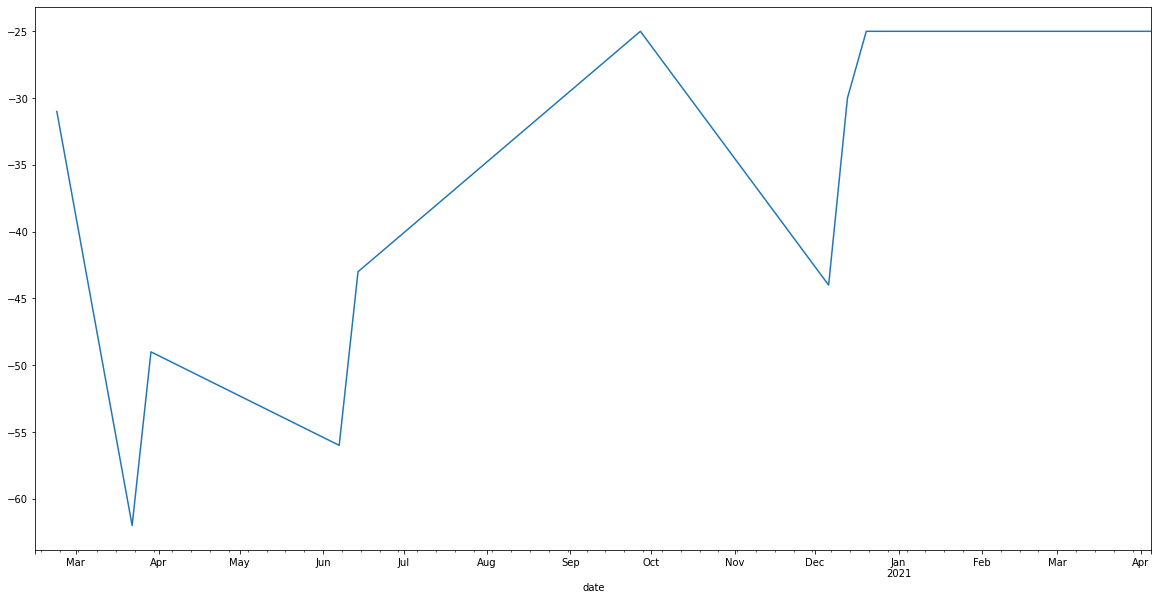

OW residential_percent_change_from_baseline (#NaN/total): (416/0)


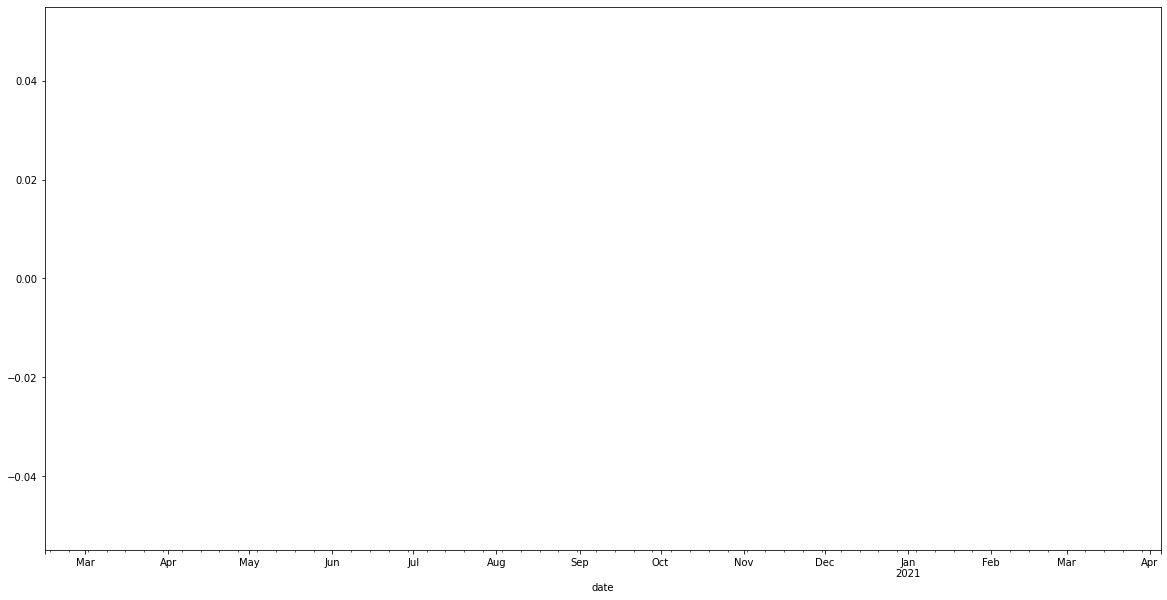

SH parks_percent_change_from_baseline (#NaN/total): (416/0)


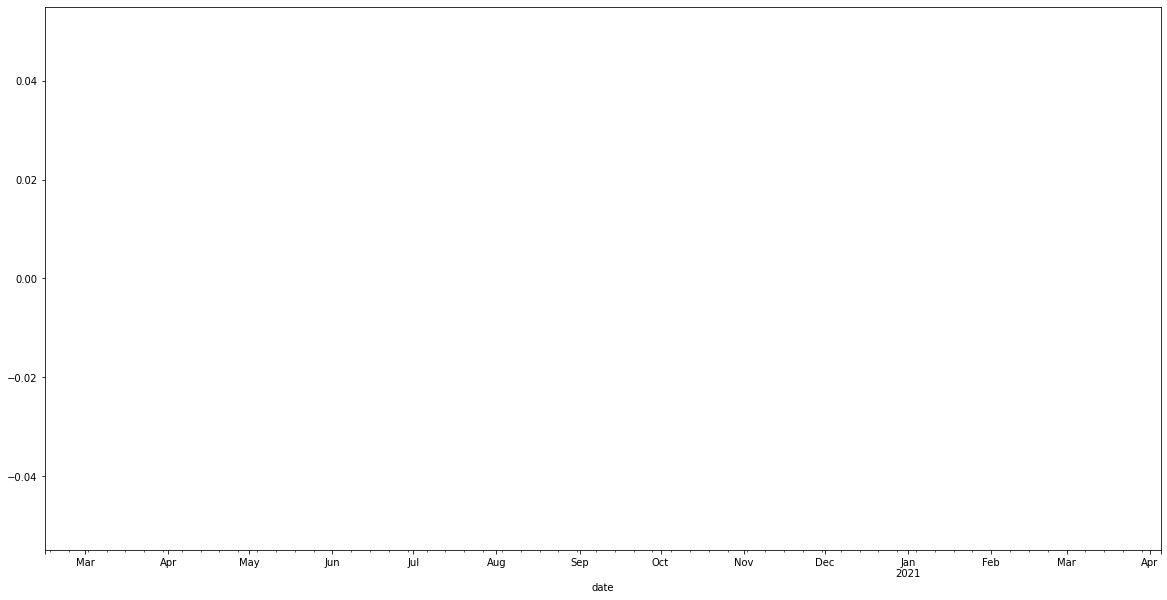

SH residential_percent_change_from_baseline (#NaN/total): (2/414)


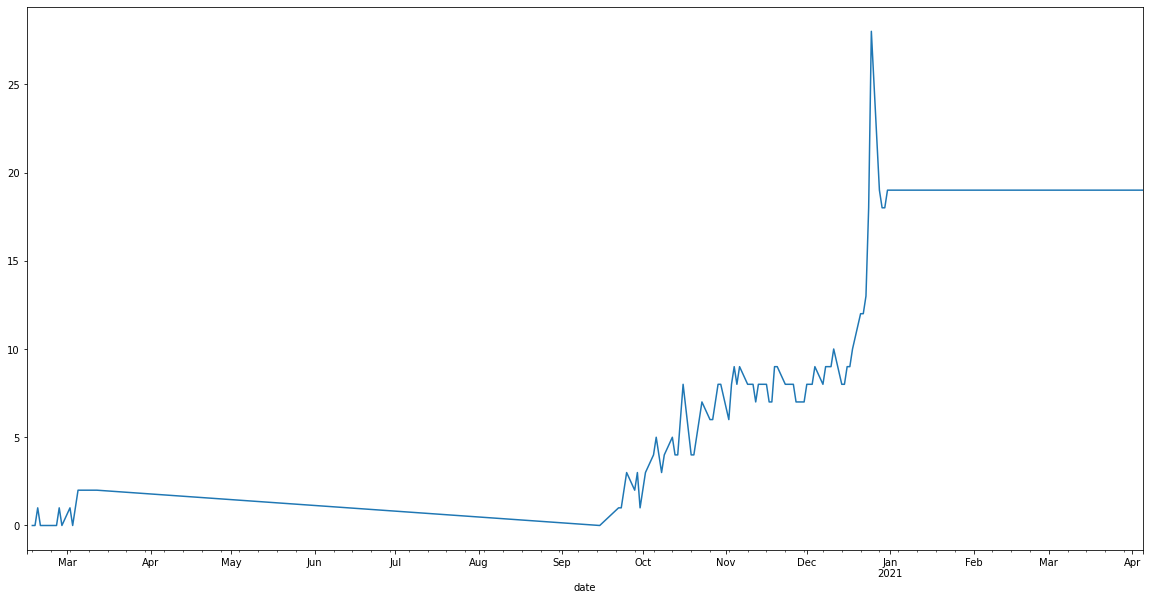

SZ parks_percent_change_from_baseline (#NaN/total): (1/415)


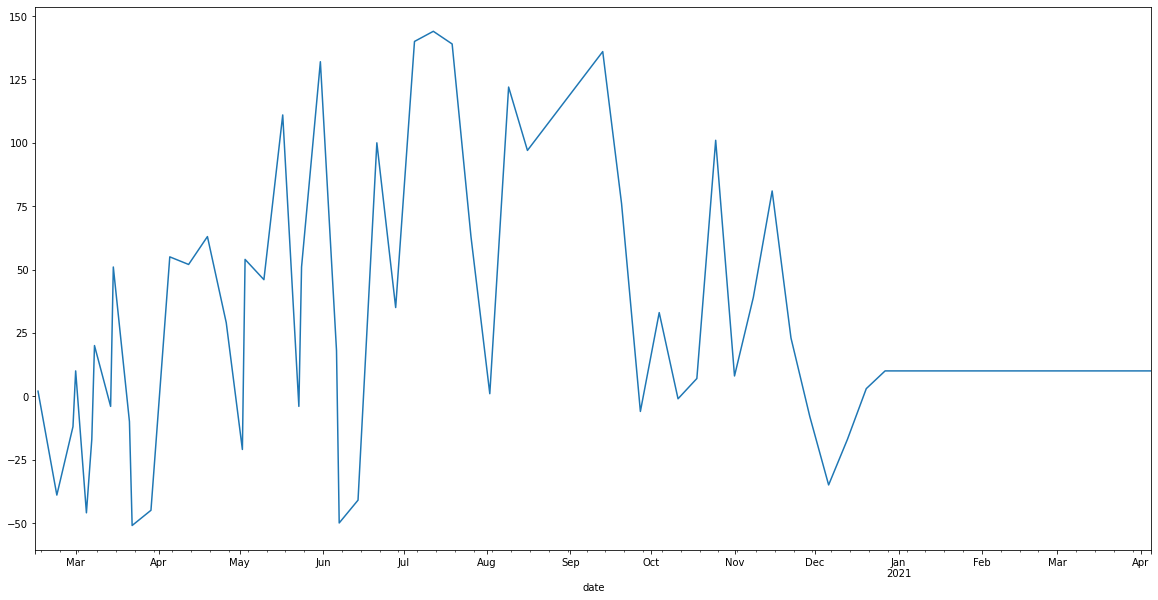

SZ residential_percent_change_from_baseline (#NaN/total): (2/414)


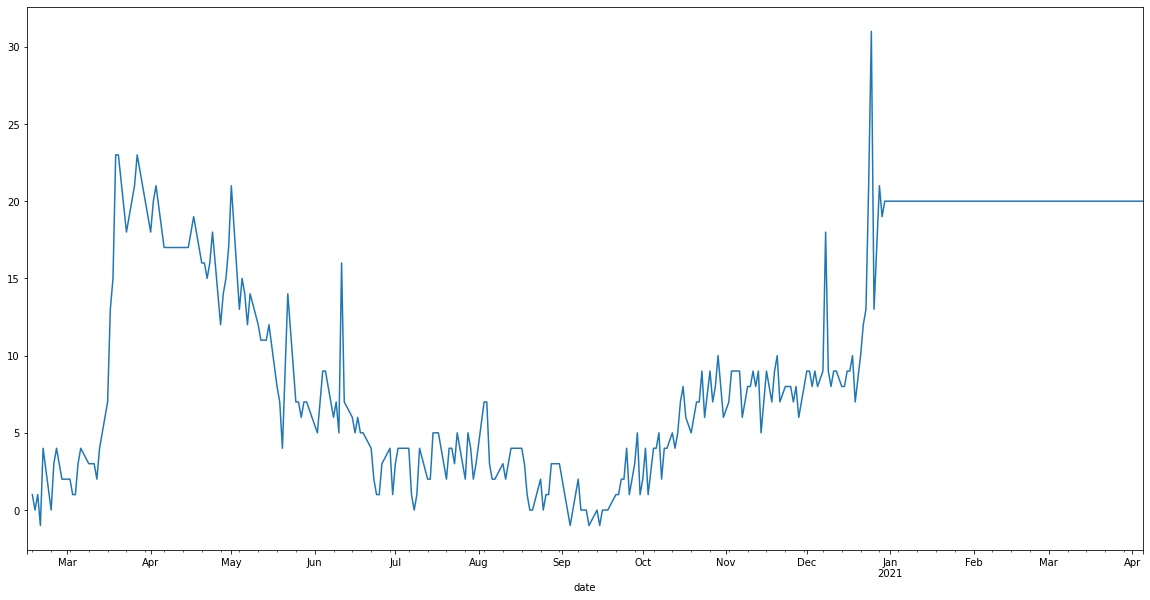

UR parks_percent_change_from_baseline (#NaN/total): (416/0)


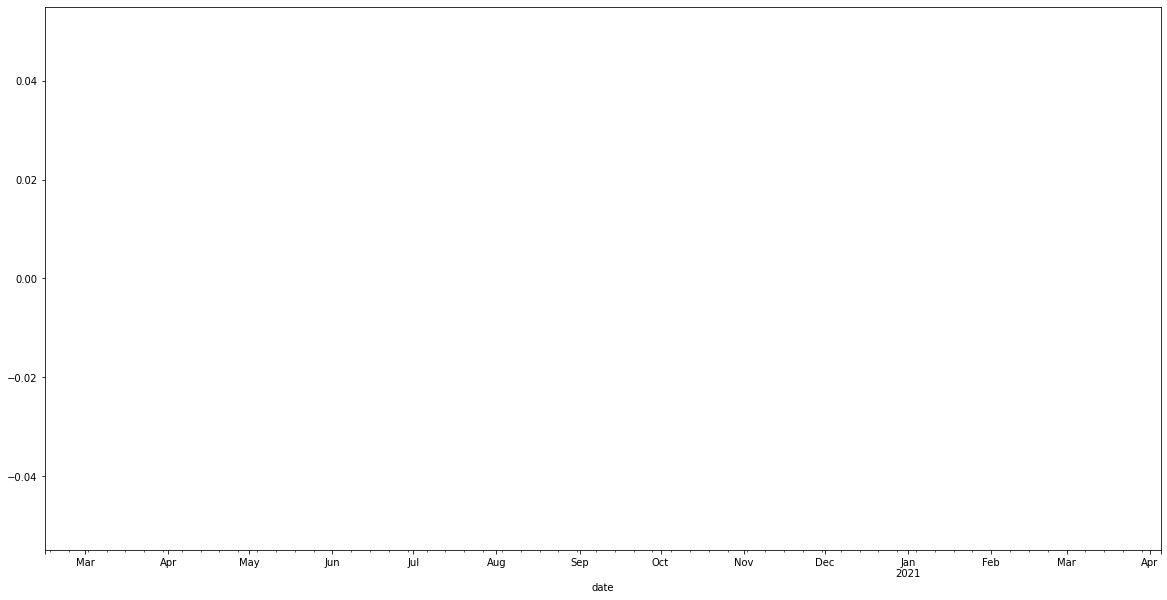

UR residential_percent_change_from_baseline (#NaN/total): (416/0)


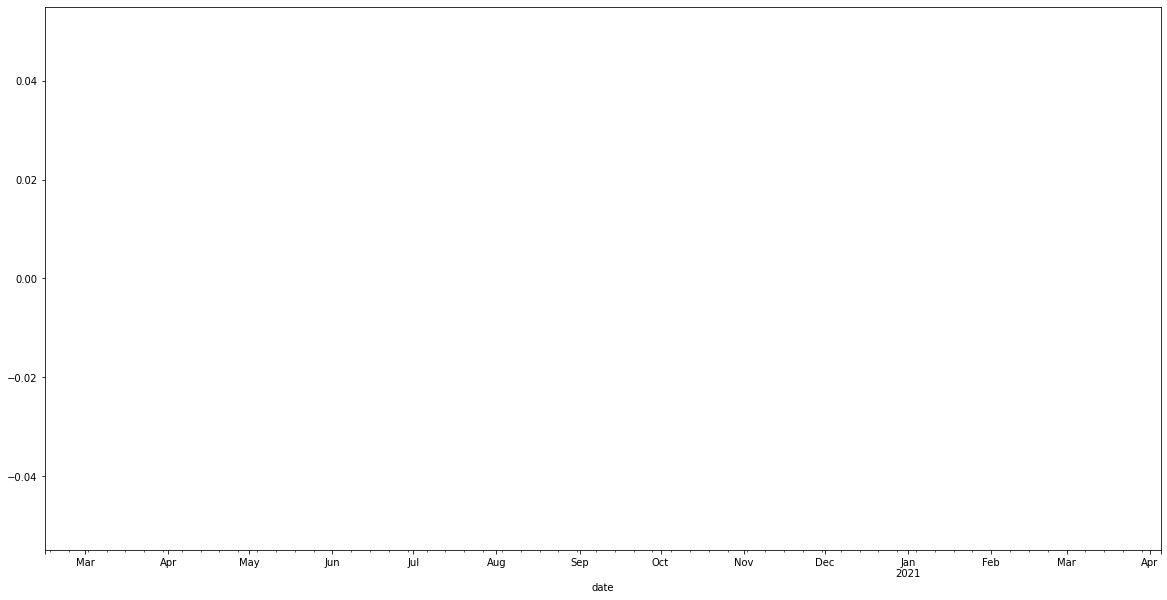

ZG parks_percent_change_from_baseline (#NaN/total): (416/0)


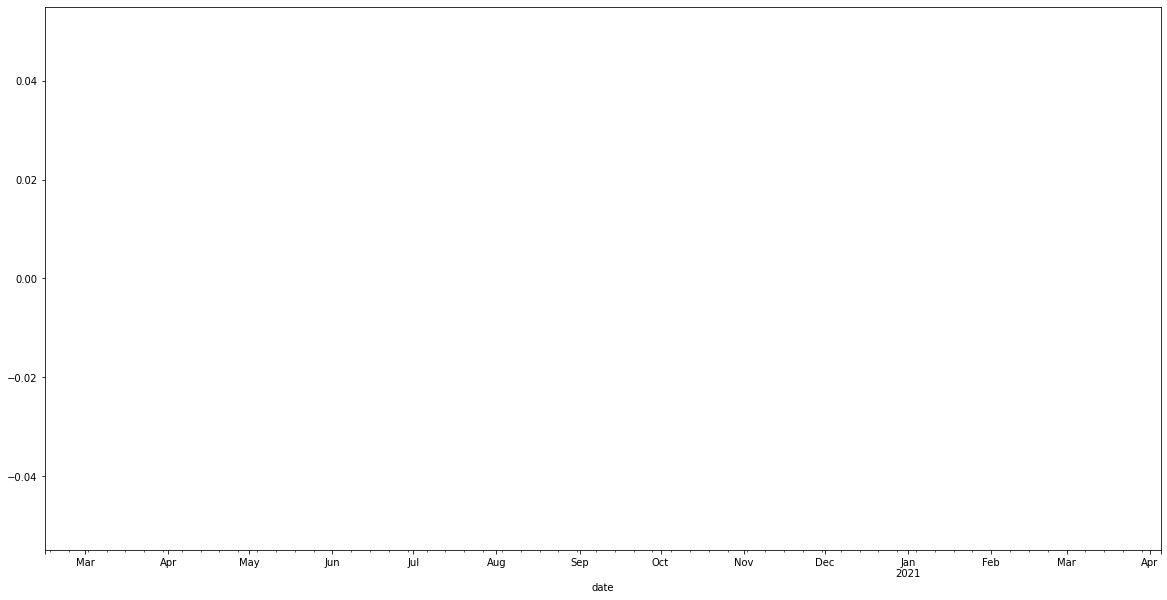

ZG residential_percent_change_from_baseline (#NaN/total): (2/414)


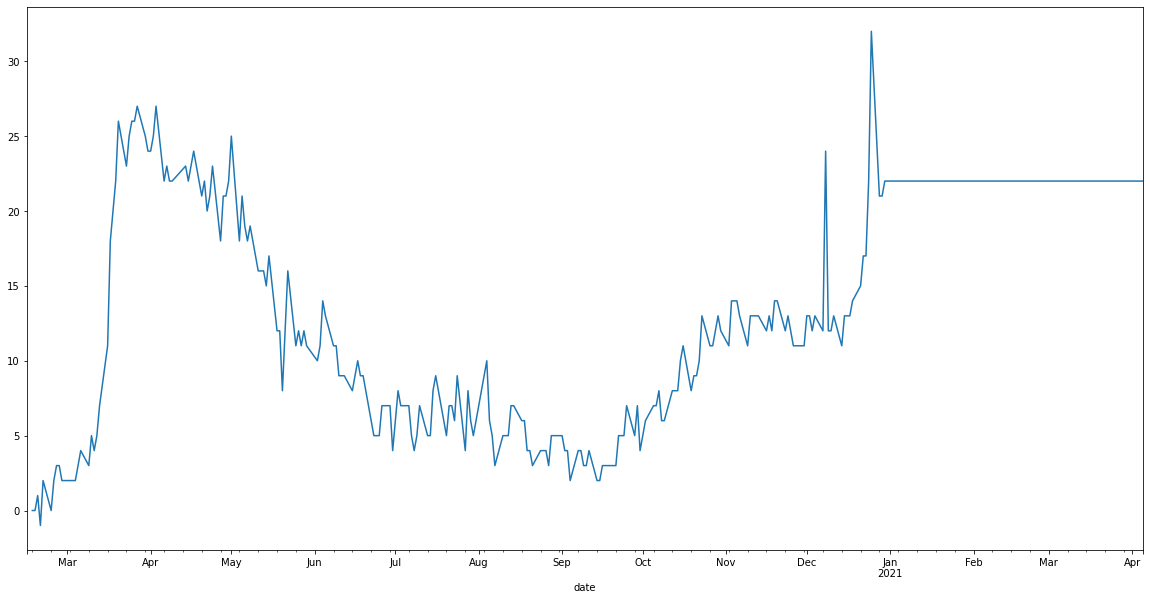

In [797]:
for cantonId in cantonKeys:
    for col in dict[cantonId].columns:
        if dict[cantonId][col].isna().sum() != 0:
            print(cantonId+" "+col+" (#NaN/total): (" + str(dict[cantonId][col].isna().sum())+"/"+str(dict[cantonId][col].notna().sum())+")")
            dict[cantonId][col].plot(kind='line',y=[col], figsize=(20,10))
            plt.show()

AI retail_and_recreation_percent_change_from_baseline (#NaN/total): (34/382)
AI grocery_and_pharmacy_percent_change_from_baseline (#NaN/total): (416/0)
AI parks_percent_change_from_baseline (#NaN/total): (416/0)
AI transit_stations_percent_change_from_baseline (#NaN/total): (416/0)
AI workplaces_percent_change_from_baseline (#NaN/total): (2/414)
AI residential_percent_change_from_baseline (#NaN/total): (416/0)
AR parks_percent_change_from_baseline (#NaN/total): (416/0)
AR residential_percent_change_from_baseline (#NaN/total): (221/195)
BL parks_percent_change_from_baseline (#NaN/total): (1/415)
BS residential_percent_change_from_baseline (#NaN/total): (2/414)
GL parks_percent_change_from_baseline (#NaN/total): (416/0)
GL residential_percent_change_from_baseline (#NaN/total): (416/0)
JU parks_percent_change_from_baseline (#NaN/total): (416/0)
JU residential_percent_change_from_baseline (#NaN/total): (2/414)
NE parks_percent_change_from_baseline (#NaN/total): (8/408)
NW parks_percent_cha

In [689]:
'''
# plotting original data
for col in dict['AG'].columns:
    comparingDf = pd.concat([dict['AG'][[col]],originalData[["original_"+col]]], axis=1)
    #comparingDf[['original_'+col]].reset_index().plot(kind='scatter', x=['date'], y=['original_'+col], figsize=(20,10))
    #comparingDf['2020-02-15':'2021-04-05'].plot(kind='line',y=[col], figsize=(20,10))
'''

'\n# plotting original data\nfor col in dict[\'AG\'].columns:\n    comparingDf = pd.concat([dict[\'AG\'][[col]],originalData[["original_"+col]]], axis=1)\n    #comparingDf[[\'original_\'+col]].reset_index().plot(kind=\'scatter\', x=[\'date\'], y=[\'original_\'+col], figsize=(20,10))\n    #comparingDf[\'2020-02-15\':\'2021-04-05\'].plot(kind=\'line\',y=[col], figsize=(20,10))\n'

In [735]:


#display([col for col in pd.read_csv("data/filled/AG.csv").columns)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (<ipython-input-735-6180fab30552>, line 9)

In [781]:
display([col for col in features.columns])
display(len([col for col in features.columns]))

['Cases inz_entries 0 - 9',
 'Cases inz_entries 10 - 19',
 'Cases inz_entries 20 - 29',
 'Cases inz_entries 30 - 39',
 'Cases inz_entries 40 - 49',
 'Cases inz_entries 50 - 59',
 'Cases inz_entries 60 - 69',
 'Cases inz_entries 70 - 79',
 'Cases inz_entries 80+',
 'Cases inzsumTotal 0 - 9',
 'Cases inzsumTotal 10 - 19',
 'Cases inzsumTotal 20 - 29',
 'Cases inzsumTotal 30 - 39',
 'Cases inzsumTotal 40 - 49',
 'Cases inzsumTotal 50 - 59',
 'Cases inzsumTotal 60 - 69',
 'Cases inzsumTotal 70 - 79',
 'Cases inzsumTotal 80+',
 'Death inz_entries 0 - 9',
 'Death inz_entries 10 - 19',
 'Death inz_entries 20 - 29',
 'Death inz_entries 30 - 39',
 'Death inz_entries 40 - 49',
 'Death inz_entries 50 - 59',
 'Death inz_entries 60 - 69',
 'Death inz_entries 70 - 79',
 'Death inz_entries 80+',
 'Death inzsumTotal 0 - 9',
 'Death inzsumTotal 10 - 19',
 'Death inzsumTotal 20 - 29',
 'Death inzsumTotal 30 - 39',
 'Death inzsumTotal 40 - 49',
 'Death inzsumTotal 50 - 59',
 'Death inzsumTotal 60 - 69',


141

In [791]:
# feature engineering
filledDict = {}

for cantonId in cantonKeys:
    d = pd.read_csv("data/filled/"+cantonId+".csv")
    d = d.set_index('date')
    filledDict[cantonId] = d
    
    features = filledDict[cantonId].copy()

    # summarize mask mandatories
    maskMandatories = [ 'Mask mandatory in publicly accessible establishments/ spaces (shops etc.)',
                       'Mask mandatory in public transport','Masks mandatory in schools','Masks mandatory at work']
    features[['maskMandatories']] = features[maskMandatories].sum(axis=1)
    features.drop(maskMandatories, axis=1, inplace=True)

    # static cantonal features
    staticCantonal = pd.read_excel("static_data/staticCantonalData.xlsx").set_index('canton').transpose()

    # r value accuracy
    features[['R_error']] = features['median_R_highHPD']-features['median_R_lowHPD']
    features.drop(['median_R_highHPD','median_R_lowHPD'],axis=1, inplace=True)

    # variants accuracy
    features[['anteil_pos','upper_ci_day','lower_ci_day']] = features[['anteil_pos','upper_ci_day','lower_ci_day']].rolling(window=14).mean()
    features[['variant_error']] = features['upper_ci_day']-features['lower_ci_day']
    features.drop(['upper_ci_day','lower_ci_day'],axis=1, inplace=True)

    # vaccine
    features.drop(['VaccDosesAdministered sumTotal','FullyVaccPersons sumTotal'],axis=1, inplace=True)
    vaccine = ['VaccDosesAdministered per100PersonsTotal',
               'FullyVaccPersons per100PersonsTotal']
    features[vaccine] = features[vaccine].rolling(window=7).mean()
    
    # test positivity rate
    #display(len(features[['case_entries']]))
    #display(len(features[['test_entries']]))
    features[['testPositvity']] = features['case_entries']/features['test_entries']

    # remove absolut values which are included in the incidenc rates
    absVal = ['Cases entries 0 - 9','Cases entries 10 - 19','Cases entries 20 - 29','Cases entries 30 - 39',
              'Cases entries 40 - 49','Cases entries 50 - 59','Cases entries 60 - 69','Cases entries 70 - 79',
              'Cases entries 80+','Death entries 0 - 9','Death entries 10 - 19','Death entries 20 - 29',
              'Death entries 30 - 39','Death entries 40 - 49','Death entries 50 - 59','Death entries 60 - 69',
              'Death entries 70 - 79','Death entries 80+', 'Hosp entries 0 - 9','Hosp entries 10 - 19',
              'Hosp entries 20 - 29','Hosp entries 30 - 39','Hosp entries 40 - 49','Hosp entries 50 - 59',
              'Hosp entries 60 - 69','Hosp entries 70 - 79','Hosp entries 80+', 'Cases entries female',
              'Cases entries male','Death entries female','Death entries male', 'Hosp entries female',
              'Hosp entries male','case_entries','hosp_entries','death_entries','test_entries']
    features.drop(absVal,axis=1, inplace=True)

    # hospital capacities
    hospCap = [ 'ICU_AllPatients',
     'ICU_Covid19Patients',
     'ICU_Capacity',
     'Total_AllPatients',
     'Total_Covid19Patients',
     'Total_Capacity',
     'ICU_NonCovid19Patients',
     'ICU_FreeCapacity',
     'Total_NonCovid19Patients',
     'Total_FreeCapacity']
    features[[col + "_inz" for col in hospCap]] = 100000*(features[hospCap]/staticCantonal.loc[[cantonId]]['residents'][0])
    features.drop(hospCap,axis=1, inplace=True)

    # households
    households = ['1PersonHouseholds', '2PersonHouseholds',
           '3PersonHouseholds', '4PersonHouseholds', '5PersonHouseholds',
           '6+PersonHouseholds']
    for h in households:
        features[[h+"_perc"]] = staticCantonal.loc[[cantonId]][h][0]/staticCantonal.loc[[cantonId]]['totalHousholds'][0]
    features[['averageHousehold']] = staticCantonal.loc[[cantonId]]['residents'][0]/staticCantonal.loc[[cantonId]]['totalHousholds'][0]

    # add static features
    staticFeatures = ['percentage 65 years or over','urbanPopulationPercent','homeownershipPercent', 
                      'livingSpaceInm2','carsPer1000inhabitants', 'publicTransportationPercent',
                      'privateMotorisedTransportPercent','DoctorsPer100Kinhabitants','residentsPerKm2']
    for f in staticFeatures:
        features[[f]] = staticCantonal.loc[[cantonId]][f][0]

    # construct settlement area feature
    residents = staticCantonal.loc[[cantonId]]['residents'][0]
    settlementArea = staticCantonal.loc[[cantonId]]['areaInKm2'][0]*(staticCantonal.loc[[cantonId]]['settlementAreaPercent'][0]/100)
    features[['residentsPerKm2SettlementArea']] = residents/settlementArea

    if not os.path.exists('data/features'):
        os.makedirs('data/features')
    features.to_csv('data/features/'+cantonId+'.csv')

In [794]:
# test cantons are (large, medium, small) (de, fr, de) SG,NE,NW
display(features.reset_index().drop(['date'], axis=1))

,Cases inz_entries 0 - 9,Cases inz_entries 10 - 19,Cases inz_entries 20 - 29,Cases inz_entries 30 - 39,Cases inz_entries 40 - 49,Cases inz_entries 50 - 59,Cases inz_entries 60 - 69,Cases inz_entries 70 - 79,Cases inz_entries 80+,Cases inzsumTotal 0 - 9,...,percentage 65 years or over,urbanPopulationPercent,homeownershipPercent,livingSpaceInm2,carsPer1000inhabitants,publicTransportationPercent,privateMotorisedTransportPercent,DoctorsPer100Kinhabitants,residentsPerKm2,residentsPerKm2SettlementArea
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,17.046727,99.338715,27.7,44.7,488.102314,46.919274,38.861409,261.0,926.805111,4072.910327
1,0.000000,0.000000,0.237778,0.175556,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,17.046727,99.338715,27.7,44.7,488.102314,46.919274,38.861409,261.0,926.805111,4072.910327
2,0.000000,0.000000,0.475556,0.351111,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,17.046727,99.338715,27.7,44.7,488.102314,46.919274,38.861409,261.0,926.805111,4072.910327
3,0.000000,0.000000,0.713333,0.526667,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,17.046727,99.338715,27.7,44.7,488.102314,46.919274,38.861409,261.0,926.805111,4072.910327
4,0.000000,0.000000,0.951111,0.702222,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,17.046727,99.338715,27.7,44.7,488.102314,46.919274,38.861409,261.0,926.805111,4072.910327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,58.957143,141.305714,131.982857,101.308571,111.161429,88.77,61.807143,33.477143,29.712857,1308.605714,...,17.046727,99.338715,27.7,44.7,488.102314,46.919274,38.861409,261.0,926.805111,4072.910327
412,45.142857,109.154286,103.527143,79.821429,86.438571,69.41,48.502857,25.742857,23.277143,1309.134286,...,17.046727,99.338715,27.7,44.7,488.102314,46.919274,38.861409,261.0,926.805111,4072.910327
413,31.328571,77.002857,75.071429,58.334286,61.715714,50.05,35.198571,18.008571,16.841429,1309.662857,...,17.046727,99.338715,27.7,44.7,488.102314,46.919274,38.861409,261.0,926.805111,4072.910327
414,17.514286,44.851429,46.615714,36.847143,36.992857,30.69,21.894286,10.274286,10.405714,1310.191429,...,17.046727,99.338715,27.7,44.7,488.102314,46.919274,38.861409,261.0,926.805111,4072.910327
